In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [ ]:

file_path = r"C:\Users\Mahsaa\OneDrive\Desktop\Social_Media_Advertising.csv"
data = pd.read_csv(file_path)
print("Data preview:\n", data.head())
print("Data info:\n")
print(data.info())

Data preview:
    Campaign_ID Target_Audience     Campaign_Goal Duration Channel_Used  \
0       529013       Men 35-44    Product Launch  15 Days    Instagram   
1       275352     Women 45-60  Market Expansion  15 Days     Facebook   
2       692322       Men 45-60    Product Launch  15 Days    Instagram   
3       675757       Men 25-34    Increase Sales  15 Days    Pinterest   
4       535900       Men 45-60  Market Expansion  15 Days    Pinterest   

   Conversion_Rate Acquisition_Cost       ROI     Location Language  Clicks  \
0             0.15          $500.00  5.790000    Las Vegas  Spanish     500   
1             0.01          $500.00  7.210000  Los Angeles   French     500   
2             0.08          $500.00  0.430000       Austin  Spanish     500   
3             0.03          $500.00  0.909824        Miami  Spanish     293   
4             0.13          $500.00  1.422828       Austin   French     293   

   Impressions  Engagement_Score Customer_Segment        Date    

In [ ]:
print("Column types before cleaning:\n", data.dtypes)

for column in data.columns:

    if data[column].dtype == 'object' and data[column].str.contains('\$').any():
        data[column] = data[column].str.replace('$', '').astype(float)
        
    if data[column].dtype == 'object' and data[column].str.match(r'\d{4}-\d{2}-\d{2}').any():
        data[column] = pd.to_datetime(data[column], errors='coerce') 

for column in data.select_dtypes(include=['datetime64[ns]']).columns:
    data[f'{column}_Year'] = data[column].dt.year
    data[f'{column}_Month'] = data[column].dt.month
    data[f'{column}_Day'] = data[column].dt.day

    
    data = data.drop(columns=[column])


missing_data = data.isnull().sum()
print("Missing values in each column:\n", missing_data)


if missing_data.any():

    data = data.dropna()
    print("Missing values removed.")
else:
    print("No missing values found.")


print("Column types after cleaning:\n", data.dtypes)

print("Cleaned data preview:\n", data.head())


Column types before cleaning:
 Campaign_ID           int64
Target_Audience      object
Campaign_Goal        object
Duration             object
Channel_Used         object
Conversion_Rate     float64
Acquisition_Cost     object
ROI                 float64
Location             object
Language             object
Clicks                int64
Impressions           int64
Engagement_Score      int64
Customer_Segment     object
Date                 object
Company              object
dtype: object


C:\Users\Mahsaa\AppData\Local\Temp\ipykernel_9588\996051368.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[column] = data[column].str.replace('$', '').astype(float)


Missing values in each column:
 Campaign_ID         0
Target_Audience     0
Campaign_Goal       0
Duration            0
Channel_Used        0
Conversion_Rate     0
Acquisition_Cost    0
ROI                 0
Location            0
Language            0
Clicks              0
Impressions         0
Engagement_Score    0
Customer_Segment    0
Company             0
Date_Year           0
Date_Month          0
Date_Day            0
dtype: int64
No missing values found.
Column types after cleaning:
 Campaign_ID           int64
Target_Audience      object
Campaign_Goal        object
Duration             object
Channel_Used         object
Conversion_Rate     float64
Acquisition_Cost    float64
ROI                 float64
Location             object
Language             object
Clicks                int64
Impressions           int64
Engagement_Score      int64
Customer_Segment     object
Company              object
Date_Year             int64
Date_Month            int64
Date_Day              int64


##همبستگی با ROI

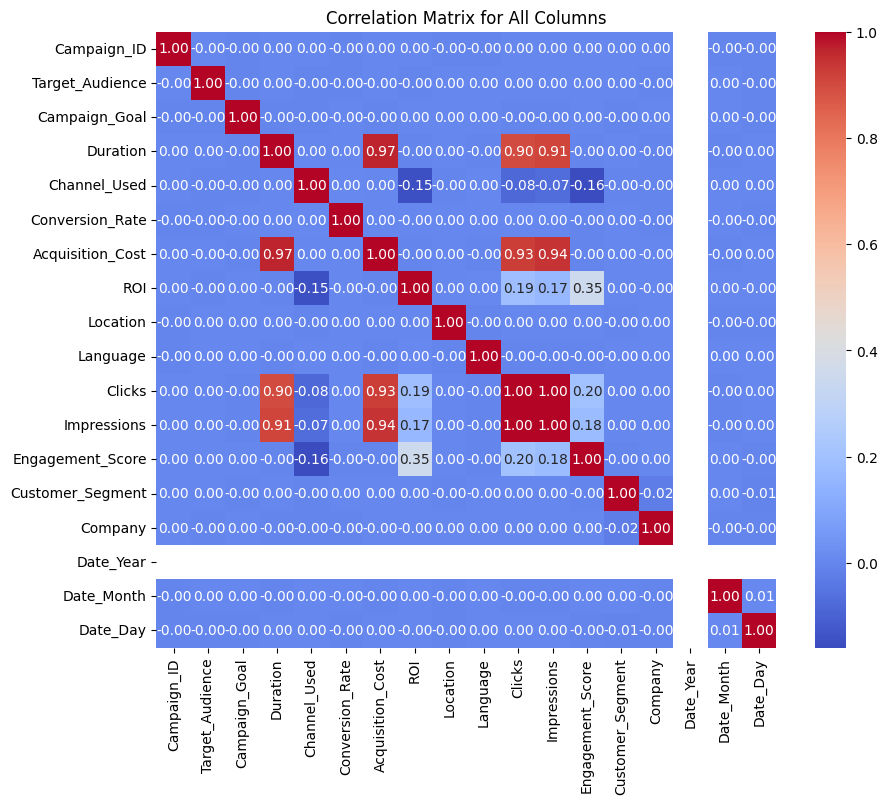

Correlation of all features with ROI:
 ROI                 1.000000
Engagement_Score    0.354717
Clicks              0.188343
Impressions         0.166009
Language            0.004138
Location            0.002576
Customer_Segment    0.002051
Campaign_Goal       0.001956
Date_Month          0.001202
Campaign_ID         0.000485
Conversion_Rate    -0.000249
Company            -0.000336
Date_Day           -0.000364
Duration           -0.001457
Acquisition_Cost   -0.001659
Target_Audience    -0.002019
Channel_Used       -0.148481
Date_Year                NaN
Name: ROI, dtype: float64


In [7]:

data_encoded = data.copy()

for column in data.columns:
    if data[column].dtype == 'object':  
        le = LabelEncoder()
        data_encoded[column] = le.fit_transform(data[column])

correlation_matrix = data_encoded.corr()
 
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for All Columns')
plt.show()


correlation_with_roi = correlation_matrix['ROI'].sort_values(ascending=False)
print("Correlation of all features with ROI:\n", correlation_with_roi)

In [ ]:

features = data_encoded.drop(columns=['ROI']).columns.tolist()
target = 'ROI'

X = data_encoded[features]
y = data_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing data shape: X={X_test.shape}, y={y_test.shape}")

Training data shape: X=(240000, 17), y=(240000,)
Testing data shape: X=(60000, 17), y=(60000,)


In [ ]:

param_grid = {
    'n_estimators': [100, 300], 
    'max_depth': [10, 15],
    'max_features': ['sqrt', 'log2']
}


rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-2,
    verbose=2  
)
 
grid_search.fit(X_train, y_train)


best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

y_pred = best_rf_model.predict(X_test)
optimized_mae = mean_absolute_error(y_test, y_pred)
optimized_r2 = r2_score(y_test, y_pred)

print("Optimized Random Forest Results:")
print(f"Mean Absolute Error (MAE): {optimized_mae}")
print(f"R² Score: {optimized_r2}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 300}
Optimized Random Forest Results:
Mean Absolute Error (MAE): 1.5884329421806096
R² Score: 0.33189299914563974


Feature Importances:
              Feature  Importance
11  Engagement_Score    0.369291
4       Channel_Used    0.299869
9             Clicks    0.088605
10       Impressions    0.069592
6   Acquisition_Cost    0.045698
0        Campaign_ID    0.024671
13           Company    0.015444
16          Date_Day    0.015441
3           Duration    0.015388
5    Conversion_Rate    0.012319
15        Date_Month    0.011060
1    Target_Audience    0.009635
7           Location    0.006843
12  Customer_Segment    0.006126
2      Campaign_Goal    0.005866
8           Language    0.004152
14         Date_Year    0.000000


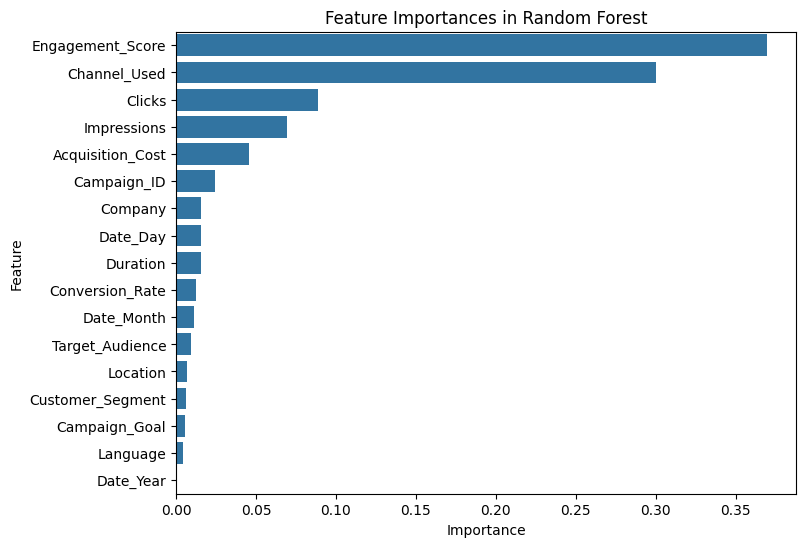

In [ ]:

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:\n", feature_importances)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances in Random Forest')
plt.show()


Sample Predictions:
    Actual  Predicted
0    6.79   3.677976
1    2.08   3.946174
2    4.49   4.061867
3    4.19   3.941153
4    5.09   3.963157


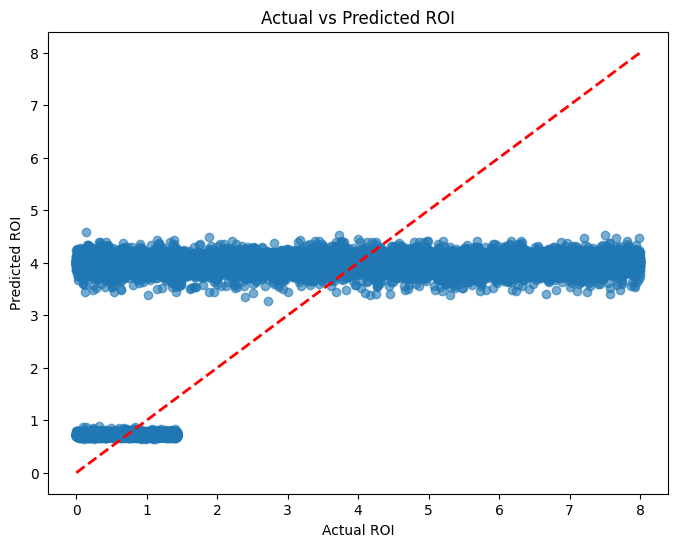

In [14]:

final_predictions = best_rf_model.predict(X_test)
 
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': final_predictions
}).reset_index(drop=True)

ا
print("Sample Predictions:\n", results_df.head())


plt.figure(figsize=(8, 6))
plt.scatter(y_test, final_predictions, alpha=0.6)
plt.title('Actual vs Predicted ROI')
plt.xlabel('Actual ROI')
plt.ylabel('Predicted ROI')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)  # خط مرجع
plt.show()


In [ ]:
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


params = {
    'objective': 'reg:squarederror',  # برای پیش‌بینی مقادیر عددی
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}
num_boost_round = 100


xgb_model = xgb.train(params, dtrain, num_boost_round)


predictions = xgb_model.predict(dtest)


from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"XGBoost MAE: {mae}")
print(f"XGBoost R²: {r2}")


XGBoost MAE: 1.5895895207633548
XGBoost R²: 0.3304528897964062


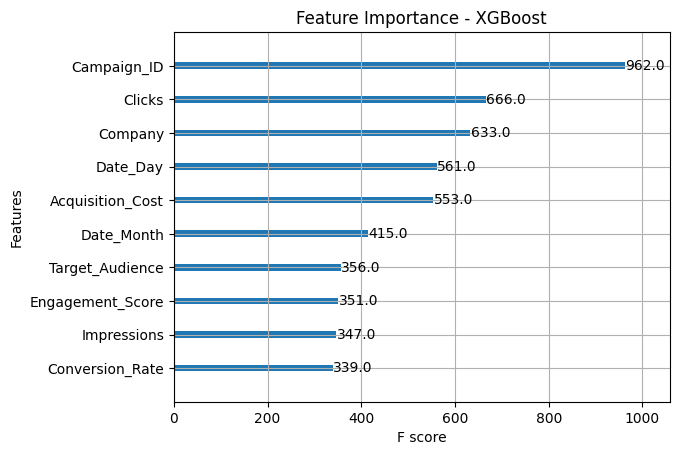

In [ ]:

plot_importance(xgb_model, max_num_features=10, importance_type='weight')
plt.title('Feature Importance - XGBoost')
plt.show()


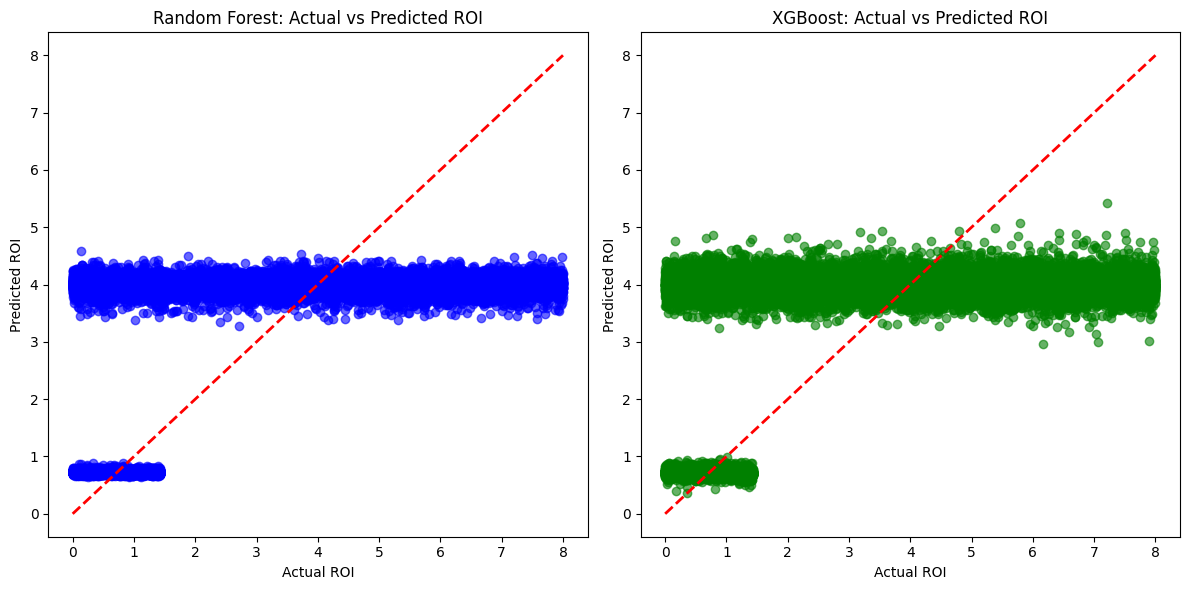

In [17]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.scatter(y_test, final_predictions, alpha=0.6, color='blue')
plt.title('Random Forest: Actual vs Predicted ROI')
plt.xlabel('Actual ROI')
plt.ylabel('Predicted ROI')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2) 
plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions, alpha=0.6, color='green')
plt.title('XGBoost: Actual vs Predicted ROI')
plt.xlabel('Actual ROI')
plt.ylabel('Predicted ROI')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2) 

plt.tight_layout()
plt.show()
